In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json
import os
from scipy.optimize import minimize_scalar
from scipy import stats

In [2]:
dir_list = [el for el in os.listdir() if el.startswith("run_ger")]
dir_list.sort(key=lambda x: os.path.getmtime(x))
run = dir_list[-1]
print(dir_list)
print("plotting run : {}".format(run))

['run_ger_2023-01-24_13-44-43', 'run_ger_2023-01-25_17-43-49', 'run_ger_2023-01-25_17-52-10', 'run_ger_2023-01-25_17-54-56', 'run_ger_2023-01-25_17-57-44', 'run_ger_2023-01-25_18-00-45', 'run_ger_2023-01-25_18-02-27', 'run_ger_2023-01-25_18-05-15', 'run_ger_2023-01-25_18-07-23', 'run_ger_2023-01-25_18-09-15', 'run_ger_2023-01-25_18-12-05', 'run_ger_2023-01-25_18-14-01', 'run_ger_2023-01-25_18-15-34', 'run_ger_2023-01-25_18-17-18', 'run_ger_2023-01-25_18-19-52', 'run_ger_2023-01-25_18-22-46', 'run_ger_2023-01-25_18-25-35', 'run_ger_2023-01-25_18-28-08', 'run_ger_2023-01-25_18-30-07', 'run_ger_2023-01-25_18-32-35', 'run_ger_2023-01-25_18-34-38', 'run_ger_2023-01-25_18-36-22', 'run_ger_2023-01-25_18-39-54']
plotting run : run_ger_2023-01-25_18-39-54


In [3]:
arr = np.load(run + "/posterior_first.npz")
data = np.load(run + "/data_info.npz")

with open(run + "/info.json") as f:
    info = json.load(f)

In [4]:
[k for k in data.files]

['sir_data',
 'day_zero',
 'date_range_x',
 'time_domain',
 'data_grid',
 'ode_grid',
 'dense_grid',
 'train_idcs',
 'val_idcs',
 'beta_prior_mean',
 'gamma']

In [5]:
def plot_data(data):
    plt.figure(figsize=(16,4))
    plt.plot(data["sir_data"][:, 0:1], '.', label="Measurement data")
    plt.legend()
    return
def plot_sir(data, posterior):
    fig, axs = plt.subplots(1,3,figsize=(16,4))
    for i, label in enumerate(["Susceptible", "Infected", "Recovered"]):
        axs[i].plot(np.exp(posterior["means"][:, (info["x_process_ordint"] + 1)*i])[::(1+int(1/info["filter_step_size"]))], label="Prediction")
        axs[i].plot(data["sir_data"][:, i], label="Data")
        axs[i].set_title(label)
        axs[i].legend()
    return

def plot_beta(posterior):
    return

def beta_link_fn(x, info, data, y_offset=0.0):
    slope = info["sigmoid_slope"]
    x_offset = -scipy.special.logit(data["beta_prior_mean"])
    return scipy.special.expit(slope * (x - x_offset)) + y_offset



## Sanity Checks

In [6]:
logS = arr["means"][:, 0]
S = np.exp(logS)
logSp = arr["means"][:, 1]
Sp = S * logSp
logI = arr["means"][:, 3]
I = np.exp(logI)
logIp = arr["means"][:, 4]
Ip = I * logIp
logR = arr["means"][:, 6]
R = np.exp(logR)
logRp = arr["means"][:, 7]
Rp = R * logRp
beta = arr["means"][:, 9]
beta_link = beta_link_fn(beta, info, data)

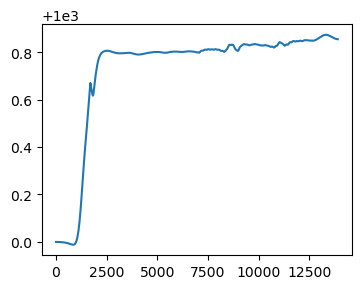

In [7]:
#Check that S + I + R = 1000 with small error (1e-2) due to diffusion noise
plt.figure(figsize=(4,3))
plt.plot(S + I + R)

In [8]:
np.mean(Rp/I), np.median(Rp/I), np.mean((Rp/I)[2500:])

(0.06171437243267133, 0.06497709230245824, 0.06491190222345863)

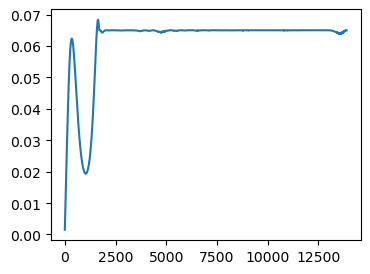

In [9]:
#Check that Rp = gamma * I, where gamma = 0.06
plt.figure(figsize=(4,3))
plt.plot(Rp / I)

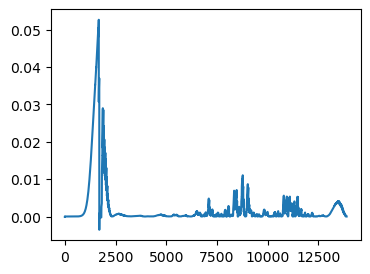

In [10]:
#Check that Sp = - S * I * beta / 1000
plt.figure(figsize=(4,3))
plt.plot(Sp + S * I * beta_link/ 1000)

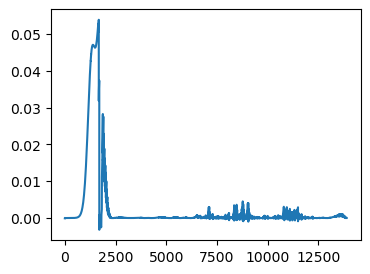

In [11]:
#Check that Ip + Sp + Rp = 0 (from Ip = -Sp - Rp)
plt.figure(figsize=(4,3))
plt.plot(Ip + Sp + Rp)

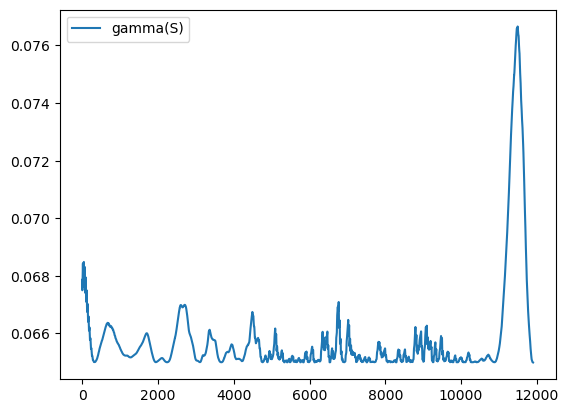

In [12]:
#gamma(S)
plt.plot((((beta_link * I * S)/1000-Ip)/I)[2000:], label="gamma(S)")
plt.legend()

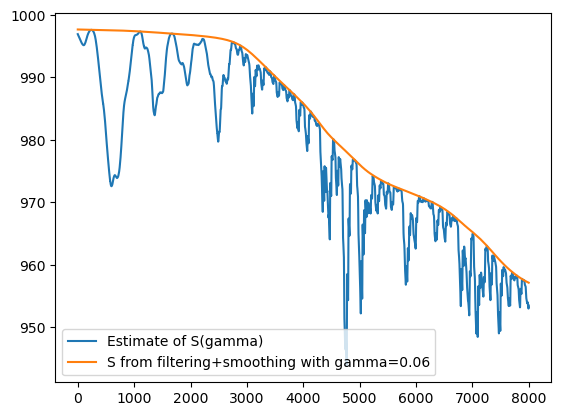

In [13]:
gamma=data["gamma"]
start_idx = 4000
end_idx = 12000
S_gamma = lambda x : (1000 * (x * I + Ip) / (beta_link * I))
plt.plot(S_gamma(gamma)[start_idx:end_idx], label="Estimate of S(gamma)")
plt.plot(S[start_idx:end_idx], label="S from filtering+smoothing with gamma=0.06")
plt.legend()

In [14]:
def opt_func(gamma, data):
    start_idx = 150
    end_idx = 500
    return np.sqrt(((data["sir_data"][start_idx:end_idx, 0] - S_gamma(gamma).reshape(-1, 25).mean(axis=1)[start_idx:end_idx])**2).sum())

In [15]:
minimize_scalar(opt_func,bracket=[0.01, 0.1], args=(data)).x

0.06525498727795828

In [16]:
#Sanity check for R
((np.log(data["sir_data"])[:,0] - arr["means"][::25,0])**2).sum()/(len(data["sir_data"][:,0]) - 1)

2.824064947138293e-09

In [17]:
#Check if we are extracting the right indices when plotting. 
#If its a list of float int, we good
data["dense_grid"][::(1+int(1/info["filter_step_size"]))][:10]

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

## Auto-correlation analysis of data

In [18]:
d = data["sir_data"][:, 1]
# Mean
mean = np.mean(d)
# Variance
var = np.var(d)

# Normalized data
ndata = d - mean

acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
acorr = acorr / var / len(ndata)

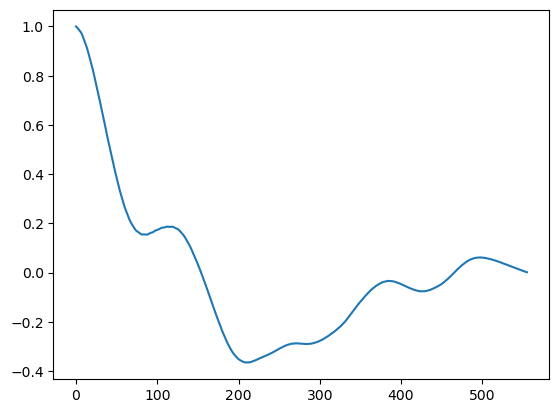

In [19]:
plt.plot(acorr)

## Plotting results

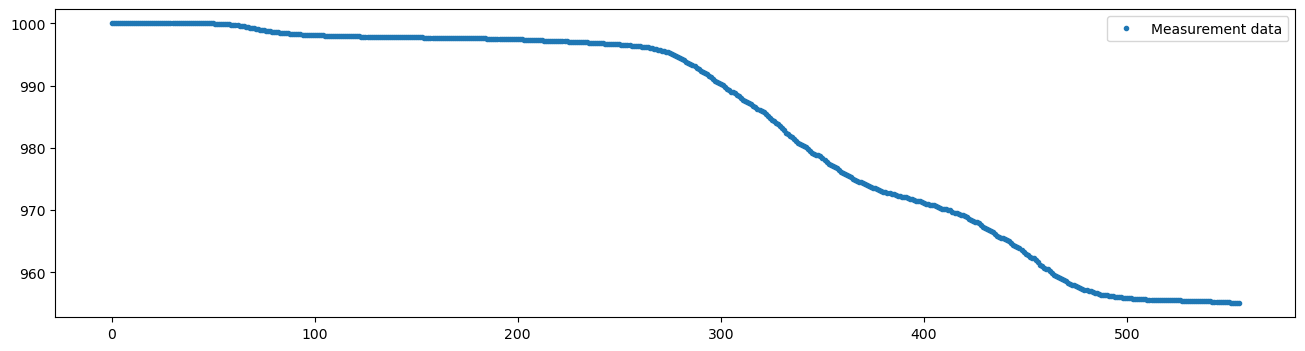

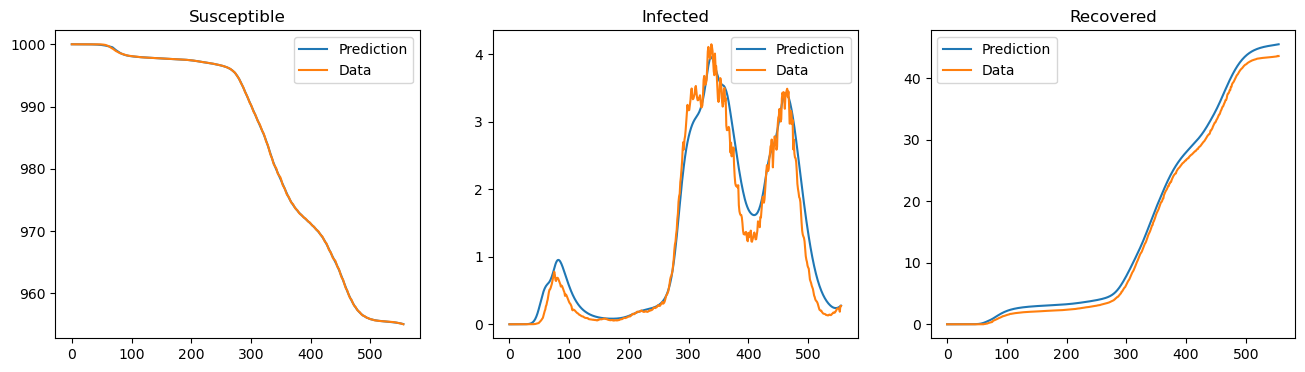

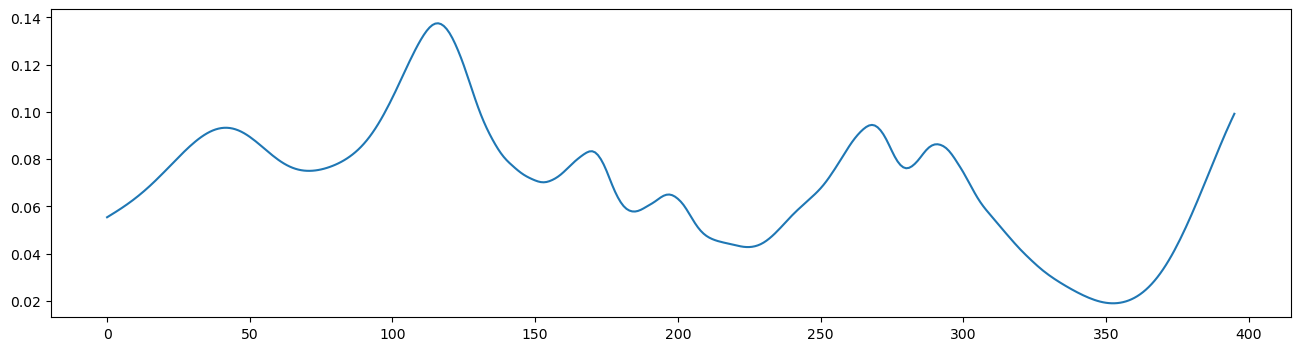

In [20]:
plot_data(data)
plot_sir(data, arr)
fig, axs = plt.subplots(1, figsize=(16,4))
axs.plot(beta_link_fn(arr["means"][4000:,-2][::1+int(1/info["filter_step_size"])], info, data))